In [1]:
from pathlib import Path
root_path = Path.cwd().parent.parent.parent.absolute()
import sys
current_dir = Path.cwd()
repo_root = current_dir.parent.parent.parent  # Go up 3 levels
pdpo_path = str(repo_root.absolute())

print(f"Current directory: {current_dir}")
print(f"Repository root: {repo_root}")

# Add repository root to path
sys.path.insert(0, pdpo_path)
print(f"✓ Added to path: {pdpo_path}")

Current directory: /work2/Sebas/PDPO_jax/pdpo/generative/notebooks
Repository root: /work2/Sebas/PDPO_jax
✓ Added to path: /work2/Sebas/PDPO_jax


In [2]:
import jax
import jax.numpy as jnp
from jax import random, jit, vmap
from flax import nnx
import optax
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from typing import Dict, Tuple, Optional
import time

In [3]:
# Set plot style
plt.style.use('default')

# JAX Configuration
print("JAX version:", jax.__version__)
print("Available devices:", jax.devices())

device = jax.devices()[0]

JAX version: 0.7.0
Available devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


In [4]:
# Set random seed for reproducibility
SEED = 1
key = random.PRNGKey(SEED)
print(f"Random seed set to: {SEED}")

Random seed set to: 1


In [5]:
from pdpo.generative.models.matching_methods import FlowMatching
from pdpo.models.nn import create_mlp,get_activation_fn
from pdpo.data.toy_datasets import inf_train_gen
from pdpo.core.types import ModelParams, SampleArray, TimeArray
from pdpo.ode.solvers import MidpointSolver

In [6]:
# Test configuration
CONFIG = {
    'model': {
        'input_dim': 2,
        'hidden_dim': 64,
        'num_layers': 4,
        'activation': 'relu',
        'time_varying': True
    },
    'training': {
        'batch_size': 1000,
        'learning_rate': 1e-3,
        'num_epochs': 200,
        'print_every': 50
    },
    'data': {
        'source': 'std_gaussian',
        'target': '8gaussians',
        'dim': 2
    }
}

In [7]:
print("Configuration loaded:")
for section, params in CONFIG.items():
    print(f"  {section}: {params}")

print("\n" + "="*50)
print("SETUP COMPLETE - Ready for Flow Matching tests")
print("="*50)

Configuration loaded:
  model: {'input_dim': 2, 'hidden_dim': 64, 'num_layers': 4, 'activation': 'relu', 'time_varying': True}
  training: {'batch_size': 1000, 'learning_rate': 0.001, 'num_epochs': 200, 'print_every': 50}
  data: {'source': 'std_gaussian', 'target': '8gaussians', 'dim': 2}

SETUP COMPLETE - Ready for Flow Matching tests


In [8]:
get_activation_fn('relu')

In [9]:
architecture = [
    CONFIG['model']['input_dim'],      # 2 - input dimension  
    CONFIG['model']['num_layers'],     # 4 - number of layers
    CONFIG['model']['hidden_dim'],     # 64 - hidden layer width
    CONFIG['model']['activation'],      # 'relu' - activation function
    CONFIG['model']['time_varying']
]

print(f"MLP Architecture: {architecture}")
print(f"  - Input dimension: {architecture[0]}")
print(f"  - Hidden width: {architecture[1]}")  
print(f"  - Number of layers: {architecture[2]}")
print(f"  - Activation: {architecture[3]}")

MLP Architecture: [2, 4, 64, 'relu', True]
  - Input dimension: 2
  - Hidden width: 4
  - Number of layers: 64
  - Activation: relu


In [10]:
vf_model = create_mlp(input_size = architecture[0],
num_layers = architecture[1],
layer_width = architecture[2],
activation = architecture[3],
time_varying = architecture[4]
)


nnx.display(vf_model)

/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/treescope/renderers.py:251: UserWarning: Ignoring error inside wrapper hook <function use_autovisualizer_if_present at 0x7bb3e70ffd80>:
Traceback (most recent call last):
  File "/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/treescope/renderers.py", line 225, in _render_subtree
    postprocessed_result = hook(
        node=node, path=path, node_renderer=render_without_this_hook
    )
  File "/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/treescope/_internal/handlers/autovisualizer_hook.py", line 47, in use_autovisualizer_if_present
    result = autoviz(node, path)
  File "/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/treescope/_internal/api/array_autovisualizer.py", line 306, in __call__
    jax.sharding.PositionalSharding
  File "/work2/Sebas/miniconda3/envs/PDPO_jax/lib/python3.13/site-packages/jax/_src/deprecations.py", line 54, in getattr
    raise Attrib

In [11]:
optimizer = nnx.Optimizer(vf_model,optax.adam(CONFIG['training']['learning_rate']),wrt = nnx.Param)


In [12]:
ode_solver = MidpointSolver

In [13]:
fm_model = FlowMatching(
    vf_model = vf_model,
    optimizer = optimizer,
    ode_solver = ode_solver
)

In [14]:
# Training setup
batch_size = CONFIG['training']['batch_size']
num_epochs = CONFIG['training']['num_epochs']
losses = []

print(f"Training config: {num_epochs} epochs, batch_size={batch_size}, lr={CONFIG['training']['learning_rate']}")

Training config: 200 epochs, batch_size=1000, lr=0.001


In [15]:
key_train = key
key_train, key_batch = random.split(key_train)
source_data = inf_train_gen(CONFIG['data']['source'], key_batch, batch_size, CONFIG['data']['dim'])
target_data = inf_train_gen(CONFIG['data']['target'], key_batch, batch_size, CONFIG['data']['dim'])

# Training step
loss, metrics = fm_model.training_step(vf_model,key_batch, source_data,target_data)

In [17]:
key_train = key
for epoch in range(num_epochs):
    # Generate training data
    key_train, key_batch = random.split(key_train)
    source_data = inf_train_gen(CONFIG['data']['source'], key_batch, batch_size, CONFIG['data']['dim'])
    target_data = inf_train_gen(CONFIG['data']['target'], key_batch, batch_size, CONFIG['data']['dim'])
    
    # Training step
    loss, metrics = fm_model.training_step(vf_model,key_batch, source_data,target_data)
    
    
    losses.append(float(loss))
    
    if epoch % CONFIG['training']['print_every'] == 0:
        print(f"Epoch {epoch:3d}: Loss = {loss:.6f}")

Epoch   0: Loss = 19.872227
Epoch  50: Loss = 9.273823
Epoch 100: Loss = 10.072942
Epoch 150: Loss = 9.463494


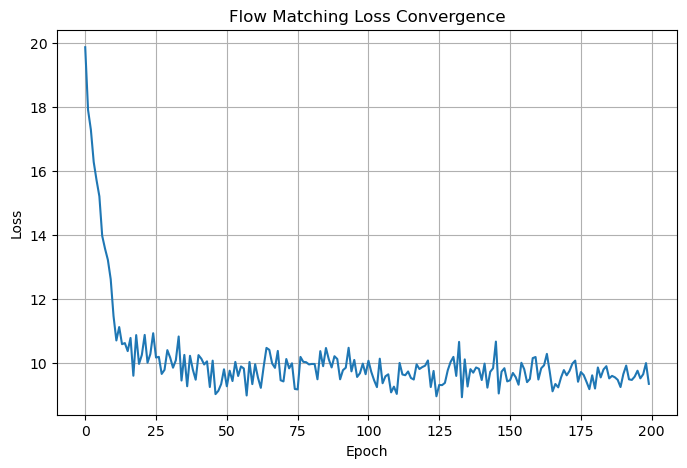

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Flow Matching Loss Convergence')
plt.grid(True)
plt.show()

In [ ]:
key_train, key_batch = random.split(key_train)
source_data = inf_train_gen(CONFIG['data']['source'], key_batch, batch_size, CONFIG['data']['dim'])

generated = flow